# Entraînement baseline (NYC Taxi Trips)

## Setup & Imports

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime

# Ajouter src/ au chemin pour importer nos modules
sys.path.append("../src")
from data_loader import download_month, load_parquet
from preprocessing import preprocess, FEATS_KEEP

# Dossier utiles
DATA_RAW = Path("../data/raw")
DATA_PROC = Path("../data/processed")
MODELS_DIR = Path("../models/trained_models")
for p in [DATA_RAW, DATA_PROC, MODELS_DIR]:
    p.mkdir(parents=True, exist_ok=True)

# Colonnes à charger depuis le parquet
USE_COLS = [
    "tpep_pickup_datetime", "tpep_dropoff_datetime",
    "passenger_count", "trip_distance",
    "PULocationID", "DOLocationID",
    "RatecodeID", "payment_type",
    "fare_amount", "extra", "mta_tax",
    "tip_amount", "tolls_amount", "improvement_surcharge",
    "total_amount", "congestion_surcharge", "airport_fee"
]

# Fenêtre temporelle
TRAIN_MONTHS = ["01", "02", "03", "04"]
VAL_MONTHS = ["05"]
TEST_MONTHS = ["06"]
YEAR = "2023"

## Ingestion des données

In [5]:
def downcast(df: pd.DataFrame) -> pd.DataFrame:
    # colonnes float
    float_cols = [
        "trip_distance", "fare_amount", "tip_amount",
        "tolls_amount", "total_amount", "trip_duration_minutes"
    ]
    for c in float_cols:
        if c in df.columns:
            s = pd.to_numeric(df[c], errors="coerce").replace([np.inf, -np.inf], np.nan)
            df[c] = s.astype("float32")

    # colonnes int/catégorielles (on remplace les NaN par -1 avant cast)
    int_cols = [
        "passenger_count", "pickup_hour", "pickup_dow", "is_weekend",
        "RatecodeID", "payment_type", "PULocationID", "DOLocationID"
    ]
    for c in int_cols:
        if c in df.columns:
            s = pd.to_numeric(df[c], errors="coerce").replace([np.inf, -np.inf], np.nan)
            s = s.fillna(-1)           # sentinelle pour "valeur manquante"
            s = s.clip(lower=-1)       # sécurité si valeurs < -1
            df[c] = s.astype("int16")
    return df


def load_months(months, year=YEAR, rows_per_month=200_000, random_state=42):
    dfs = []
    for m in months:
        path = download_month(m, year=year)
        df_raw = load_parquet(path, use_cols=USE_COLS)
        df_clean = preprocess(df_raw)
        # SAMPLE pour limiter la RAM
        n = min(rows_per_month, len(df_clean))
        df_clean = df_clean.sample(n, random_state=random_state)
        df_clean["set_month"] = f"{year}-{m}"
        df_clean = downcast(df_clean)
        dfs.append(df_clean)
    return pd.concat(dfs, axis=0, ignore_index=True)

# Charger les jeux de données
train_df = load_months(TRAIN_MONTHS, rows_per_month=200_000)
val_df = load_months(VAL_MONTHS, rows_per_month=100_000)
test_df = load_months(TEST_MONTHS, rows_per_month=100_000)

train_df.shape, val_df.shape, test_df.shape, train_df.memory_usage(deep=True).sum() / 1e6

✅ Déjà téléchargé : /home/arnaud/Documents/mlops-taxi-pipeline/notebooks/../src/../data/raw/yellow_tripdata_2023-01.parquet
🔄 Téléchargement 2023-02...
🔄 Téléchargement 2023-03...
🔄 Téléchargement 2023-04...
🔄 Téléchargement 2023-05...
🔄 Téléchargement 2023-06...


((800000, 15), (100000, 15), (100000, 15), 83.200128)

## Séparer Features / Target

In [6]:
TARGET = "trip_duration_minutes"

# Features pour la baseline
NUM_FEATS = ["trip_distance", "passenger_count", "pickup_hour", "pickup_dow", "is_weekend"]
CAT_FEATS = ["RatecodeID", "payment_type"]
FEATS = NUM_FEATS + CAT_FEATS

# Split
X_train = train_df[FEATS].copy()
y_train = train_df[TARGET].copy()

X_val = val_df[FEATS].copy()
y_val = val_df[TARGET].copy()

X_test = test_df[FEATS].copy()
y_test = test_df[TARGET].copy()

X_train.head()

,trip_distance,passenger_count,pickup_hour,pickup_dow,is_weekend,RatecodeID,payment_type
0,1.95,1,15,6,1,1,1
1,5.50,1,20,0,0,1,1
2,0.54,1,13,5,1,1,1
3,3.30,1,11,1,0,1,1
4,0.60,4,22,4,0,1,1


## Préprocesseur sklearn

In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Encodage des variables catégorielles + normalisation des numériques
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(with_mean=True, with_std=True), NUM_FEATS),
        # dense=True car peu de classe (RatecodeID, payment_type)
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), CAT_FEATS),
    ],
    remainder="drop"
)
preprocessor

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['trip_distance', 'passenger_count',
                                  'pickup_hour', 'pickup_dow', 'is_weekend']),
                                ('cat',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['RatecodeID', 'payment_type'])])

## Modèles Baseline

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import math

def evaluate(model, X_tr, y_tr, X_v, y_v):
    pred_tr = model.predict(X_tr)
    pred_v = model.predict(X_v)
    metrics = {
        "train_mae": mean_absolute_error(y_tr, pred_tr),
        "train_rmse": math.sqrt(mean_squared_error(y_tr, pred_tr)),
        "train_r2": r2_score(y_tr, pred_tr),
        "val_mae": mean_absolute_error(y_v, pred_v),
        "val_rmse": math.sqrt(mean_squared_error(y_v, pred_v)),
        "val_r2": r2_score(y_v, pred_v),
    }
    return metrics

# Modèle 1 - Linear Regression
linreg = Pipeline ([
    ("prep", preprocessor),
    ("model", LinearRegression())
])

# Modèle 2 - HistGradientBoosting (souvent meilleur)
hgb = Pipeline([
    ("prep", preprocessor),
    ("model", HistGradientBoostingRegressor( 
        learning_rate=0.1,
        max_depth=None,
        max_iter=300,
        early_stopping=True,       # <- important
        validation_fraction=0.1,   # <- utilise 10% du train en interne
        n_iter_no_change=10,
        random_state=42
    ))
])

models = {"linreg": linreg, "hgb": hgb}
models

{'linreg': Pipeline(steps=[('prep',
                  ColumnTransformer(transformers=[('num', StandardScaler(),
                                                   ['trip_distance',
                                                    'passenger_count',
                                                    'pickup_hour', 'pickup_dow',
                                                    'is_weekend']),
                                                  ('cat',
                                                   OneHotEncoder(handle_unknown='ignore',
                                                                 sparse_output=False),
                                                   ['RatecodeID',
                                                    'payment_type'])])),
                 ('model', LinearRegression())]),
 'hgb': Pipeline(steps=[('prep',
                  ColumnTransformer(transformers=[('num', StandardScaler(),
                                                   ['trip_distance

## MLflow

In [10]:
import mlflow

mlflow.set_tracking_uri("file:../mlruns")
mlflow.set_experiment("baseline-training")

results = {}

for name, pipe in models.items():
    with mlflow.start_run(run_name=name):
        mlflow.log_param("year", YEAR)
        mlflow.log_param("train_months", ",".join(TRAIN_MONTHS))
        mlflow.log_param("val_months", ",".join(VAL_MONTHS))
        mlflow.log_param("features_num", NUM_FEATS)
        mlflow.log_param("features_cat", CAT_FEATS)
        mlflow.log_param("model_name", name)

        pipe.fit(X_train, y_train)
        metrics = evaluate(pipe, X_train, y_train, X_val, y_val)
        for k, v in metrics.items():
            mlflow.log_metric(k, float(v))
        results[name] = metrics

results

{'linreg': {'train_mae': 4.663666275149435,
  'train_rmse': 6.756306827253436,
  'train_r2': 0.6774756728457811,
  'val_mae': 5.400844618561268,
  'val_rmse': 8.168012518081138,
  'val_r2': 0.649733119326102},
 'hgb': {'train_mae': 3.3857958282031304,
  'train_rmse': 5.285715559520421,
  'train_r2': 0.8025981006638033,
  'val_mae': 3.9662491800235484,
  'val_rmse': 6.474950174066684,
  'val_r2': 0.7798903176799904}}

## Sélection meilleur Modèle & Évaluation Test

In [12]:
# Sélection par MAE sur la validation
best_name = sorted(results.items(), key=lambda kv: kv[1]["val_mae"])[0][0]
best_model = models[best_name]

# Réentraîner sur Train + Val
X_trval = pd.concat([X_train, X_val], axis=0)
y_trval = pd.concat([y_train, y_val], axis=0)
best_model.fit(X_trval, y_trval)

# Évaluer sur Test
y_pred_test = best_model.predict(X_test)
test_metrics = {
    "test_mae": mean_absolute_error(y_test, y_pred_test),
    "test_rmse": math.sqrt(mean_squared_error(y_test, y_pred_test)),
    "test_r2": r2_score(y_test, y_pred_test),
}
best_name, test_metrics

('hgb',
 {'test_mae': 3.859428765196878,
  'test_rmse': 6.134204549590706,
  'test_r2': 0.796565281719407})

## Sauvegarder le meilleur modèle

In [13]:
import joblib

model_path = MODELS_DIR / f"baseline_{best_name}_sklearn.joblib"
joblib.dump(best_model, model_path)
model_path

PosixPath('../models/trained_models/baseline_hgb_sklearn.joblib')

## Visualisation des Résidus

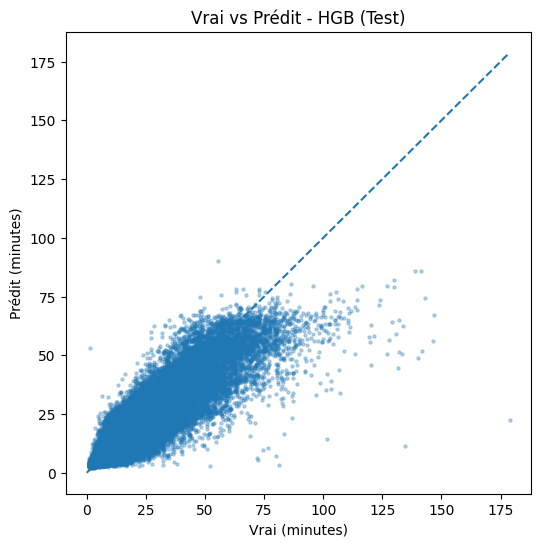

In [14]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_test, s=5, alpha=0.3)
plt.xlabel("Vrai (minutes)")
plt.ylabel("Prédit (minutes)")
plt.title(f"Vrai vs Prédit - {best_name.upper()} (Test)")
lims = [0, max(y_test.max(), y_pred_test.max())]
plt.plot(lims, lims, linestyle="--")
plt.show()

Le nuage "en banane" sur le scatter dit trois choses :
- **Sous-prédiction** quand la durée > 40-60 min (la diagonale est au-dessus du nuage)
- **Hétéroscédasticité** (variance des erreurs qui augmente avec la distance/la durée)
- **Baselin encore "myope"** (sans géo et sans features calendrier avancées)

## Ajout de diagnostic

### Distribution des erreurs et métriques clés

/tmp/ipykernel_28415/3082157402.py:15: RuntimeWarning: invalid value encountered in sqrt
  RMSE = np.sqrt(np.mean(err*2))


MAE : 3.8594 RMSE : nan MedAE : 2.4125


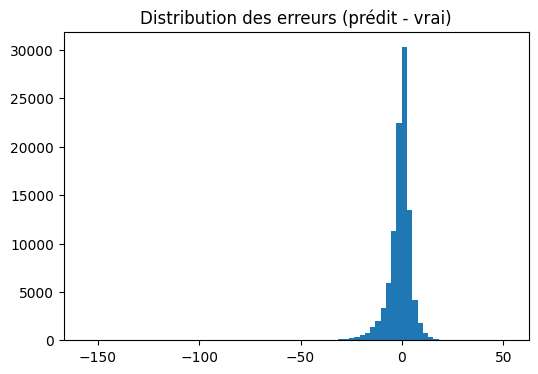

In [18]:
import numpy as np
import matplotlib.pyplot as plt

err = (y_pred_test.astype("float64") - y_test.astype("float64").values)

# Filtre des valeurs non-finies
mask = np.isfinite(err)
dropped = (~mask).sum()
if dropped:
    print(f"[INFO] Valeurs non finies ignorées : {dropped}/{err.size}")

err = err[mask]

MAE = np.mean(np.abs(err))
RMSE = np.sqrt(np.mean(err*2))
MedAE = np.median(np.abs(err))

print(f"MAE : {MAE:.4F} RMSE : {RMSE:.4f} MedAE : {MedAE:.4f}")

plt.figure(figsize=(6,4))
plt.hist(err, bins=80)
plt.title("Distribution des erreurs (prédit - vrai)")
plt.show()

### Erreur vs distance (pour confirmer la sous-prédiction)

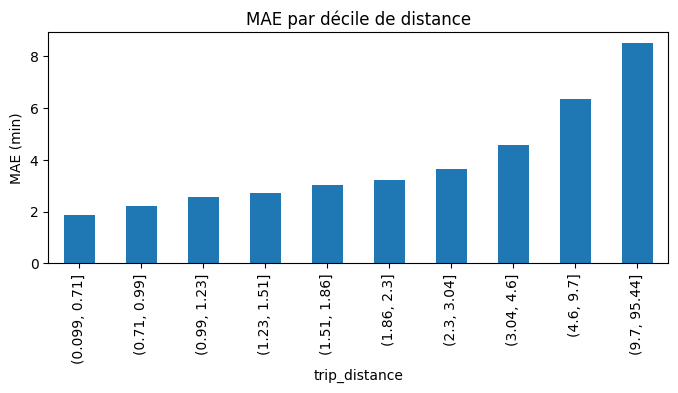

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

tmp = test_df[["trip_distance"]].copy()
tmp["y_true"] = y_test.values
tmp["y_pred"] = y_pred_test
tmp["abs_err"] = (tmp["y_pred"] - tmp["y_true"]).abs()

# Drop lignes avec NaN sur les colonnes utilisées
tmp = tmp.replace([np.inf, -np.inf], np.nan).dropna(subset=["trip_distance","abs_err"])

# Bins en déciles; duplicates='drop' évite l'erreur si quelques quantiles sont identiques
bins = pd.qcut(tmp["trip_distance"], q=10, duplicates="drop")

ax = tmp.groupby(bins, observed=True)["abs_err"].mean().plot(kind="bar", figsize=(8,3))
ax.set_title("MAE par décile de distance")
ax.set_ylabel("MAE (min)")
ax.set_xlabel("trip_distance")
plt.show()

### Importance des features (permutation)

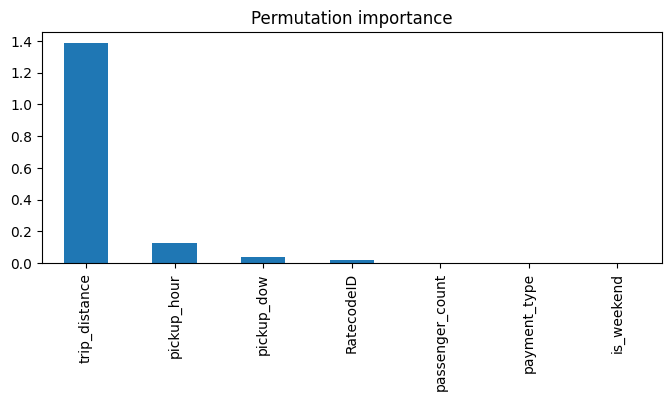

trip_distance      1.386133
pickup_hour        0.125865
pickup_dow         0.035267
RatecodeID         0.019972
passenger_count    0.000762
payment_type       0.000689
is_weekend         0.000160
dtype: float64

In [17]:
from sklearn.inspection import permutation_importance

r = permutation_importance(best_model, X_test, y_test, n_repeats=5, random_state=42, n_jobs=-1)
imp = pd.Series(r.importances_mean, index=FEATS).sort_values(ascending=False)
imp.plot(kind="bar", figsize=(8,3)); plt.title("Permutation importance"); plt.show()
imp